# Initial Analysis of the Fan Fiction Dataset

The dataset can be downloaded here: https://pan.webis.de/clef21/pan21-web/author-identification.html

The description of the dataset, also found at the previous link is: 

```The train (calibration) and test datasets consists of pairs of (snippets from) two different fanfics, that were obtained drawn from fanfiction.net. Each pair was assigned a unique identifier and we distinguish between same-author pairs and different-authors pairs. Additionally, we offer metadata on the fandom (i.e. thematic category) for each text in the pair (note that fanfic "crossovers" were not included and only single-fandom texts were considered). The fandom distribution in these datasets maximally approximates the (long-tail) distribution of the fandoms in the original dataset. The test dataset is structured in the exact same way, but participants should expect a significant shift in the relation between authors and fandoms.

The training dataset comes in two variants: a smaller dataset, particularly suited for symbolic machine learning methods and a large, dataset, suitable for applying data-hungry deep learning algorithms. Participants have to specify which of the two datasets was used to train their model. Models using the small set will be evaluated separately from models using the large set. We encourage participants to try the small dataset as a challenge, though participants can submit separate submissions for either one or both.

Both the small and the large dataset come with two newline delimited JSON files each (*.jsonl). The first file contains pairs of texts (each pair has a unique ID) and their fandom labels:

{"id": "6cced668-6e51-5212-873c-717f2bc91ce6", "fandoms": ["Fandom 1", "Fandom 2"], "pair": ["Text 1...", "Text 2..."]}
{"id": "ae9297e9-2ae5-5e3f-a2ab-ef7c322f2647", "fandoms": ["Fandom 3", "Fandom 4"], "pair": ["Text 3...", "Text 4..."]}
...
The second file, ending in *_truth.jsonl, contains the ground truth for all pairs. The ground truth is composed of a boolean flag indicating if texts in a pair are from the same author and the numeric author IDs:

{"id": "6cced668-6e51-5212-873c-717f2bc91ce6", "same": true, "authors": ["1446633", "1446633"]}
{"id": "ae9297e9-2ae5-5e3f-a2ab-ef7c322f2647", "same": false, "authors": ["1535385", "1998978"]}
...
Data and ground truth are in the same order and can be ingested line-wise in parallel without the need for a reshuffle based on the pair ID. The fandom labels will be given in both the training and testing datasets. The ground truth file will only be available for the training data.
```

## Key Notes 
1. Each data point contains snippets of text from two different fanfics.
2. Fanfic "crossovers" were not included (so texts originate from only one fandom)
3. "The fandom distribution in these datasets maximally approximates the (long-tail) distributuion of the fandoms in the original dataset" (I'm not sure what they mean here. 
4. Participants should expect a significant shift in the relation between authors and fandoms between the train and test set. 

## What questions do we have? 
1. How many fandoms?
2. How many authors? 
3. What is the distribution of texts/author? fandoms/author? author/fandom?
4. In the given pairs, what is the percentage of same author pairs vs different author pairs? 
5. Are pairs constructed only with texts from the same (or different) fandoms?
6. Is the training/testing set balanced (both the one I created and what should we expect)?
7. What is the accuracy on the dataset if we just predict the most common author/score?

In [6]:
import json 
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from multiprocessing import Pool
import time
import numpy as np

In [2]:
# First, read in the data 
# Start by getting the truth file
truth = {}
first_id = None
with open('/home/jtyo/Repos/AuthorshipAttribution/data/PAN20/pan20-authorship-verification-training-large/pan20-authorship-verification-training-large-truth.jsonl', 'r') as f:

    lines = f.readlines()

    for line in lines:
        
        line = json.loads(line)
        
        if line['id'] not in truth.keys():
            truth[line['id']] = {}
            
        if first_id is None:
            first_id = line['id']
            
        truth[line['id']]['authors'] = line['authors']
        truth[line['id']]['same'] = line['same']

# Now read the training data - I think all we need is the fandoms
data = None
with open('/home/jtyo/Repos/AuthorshipAttribution/data/PAN20/pan20-authorship-verification-training-large/pan20-authorship-verification-training-large.jsonl', 'r') as f:
    
    for line in tqdm(f):
        
        line = json.loads(line)
        
        if data is None:
            data = {'id': [line['id']],
                    'same': [truth[line['id']]['same']], 
                    'fandom1': [line['fandoms'][0]], 
                    'fandom2': [line['fandoms'][1]],
                    'auth1': [truth[line['id']]['authors'][0]],
                    'auth2': [truth[line['id']]['authors'][1]],
                    'text_len1': [len(line['pair'][0])],
                    'text_len2': [len(line['pair'][1])]
                   }
        else:
            data['id'].append(line['id'])
            data['same'].append(truth[line['id']]['same'])
            data['fandom1'].append(line['fandoms'][0])
            data['fandom2'].append(line['fandoms'][1])
            data['auth1'].append(truth[line['id']]['authors'][0])
            data['auth2'].append(truth[line['id']]['authors'][1])
            data['text_len1'].append(len(line['pair'][0]))
            data['text_len2'].append(len(line['pair'][1]))
        
data = pd.DataFrame(data=data)

0it [00:00, ?it/s]

In [3]:
# now get all of the data from the dataframe.
data.describe()

,text_len1,text_len2
count,275565.000000,275565.000000
mean,21432.899864,21422.731813
std,2775.539125,1800.413904
min,20552.000000,20355.000000
25%,21196.000000,21196.000000
50%,21285.000000,21285.000000
75%,21424.000000,21423.000000
max,943947.000000,331334.000000


In [4]:
data.head()

,id,same,fandom1,fandom2,auth1,auth2,text_len1,text_len2
0,6b177179-72d2-5c87-ba2e-7678ae8c1db2,True,Labyrinth,Mighty Boosh,4027030,4027030,21247,21285
1,80ff51a1-8f2b-507e-bece-e0a187f26a19,True,Labyrinth,Rocky Horror,4027030,4027030,21218,21230
2,b6492f44-4d7b-51d2-a6c8-fdfaf62868e4,True,Labyrinth,Shake It Up!,4027030,4027030,21351,21182
3,c502df34-8c2e-5a86-9555-cdcf0b03f189,True,Mighty Boosh,Rocky Horror,4027030,4027030,21249,21293
4,653cfc2d-5e82-5afa-87b1-c5b793441483,True,Mighty Boosh,Shake It Up!,4027030,4027030,21331,21223


In [5]:
# how many are same author pairs?
num_same = len(data[data['same'] == True])
print(f'There are {len(data)} pairs, {num_same} of them are same author, which is {num_same/len(data)} percent.')

# how many are same fandom?
num_same_fandom = len(data[data['fandom1'] == data['fandom2']])
print(f'{num_same_fandom} are same fandom, or {num_same_fandom/len(data)} percent.')

# what percent of the same author, (and diff auth pairs) are same fandom?
tmp = data[data['same'] == True]
same_auth_same_fandom = len(tmp[tmp['fandom1'] == tmp['fandom2']])
print(f'Of the same author pairs, {same_auth_same_fandom} of them are same fandom, or {same_auth_same_fandom/num_same} percent.')

tmp = data[data['same'] == False]
diff_auth_same_fandom = len(tmp[tmp['fandom1'] == tmp['fandom2']])
print(f'Of the different author pairs, {diff_auth_same_fandom} of them are same fandom, or {diff_auth_same_fandom/num_same} percent.')

# how many fandoms?
num_fandom1 = len(pd.unique(data['fandom1']))
num_fandom2 = len(pd.unique(data['fandom2']))
print(f'there were {num_fandom1} and {num_fandom2} fandoms.')

# how many authors?
num_auth1 = len(pd.unique(data['auth1']))
num_auth2 = len(pd.unique(data['auth2']))
print(f'there were {num_auth1} and {num_auth2} authors.')

# how many samples per author? (multiprocess for speed)

def get_texts_for_auth(auth):
    return len(data[data['auth1'] == auth])

print('getting all auths')

all_auths = pd.unique(data['auth1'])
start_time = time.time()
texts_per_auth = [] 

with Pool(8) as p:
    texts_per_auth.append(p.map(get_texts_for_auth, all_auths))

print(f'took {time.time() - start_time} seconds')



There are 275565 pairs, 147778 of them are same author, which is 0.5362727487162738 percent.
23131 are same fandom, or 0.08394026817629234 percent.
Of the same author pairs, 0 of them are same fandom, or 0.0 percent.
Of the different author pairs, 23131 of them are same fandom, or 0.15652532853334056 percent.
there were 1600 and 1600 fandoms.
there were 160159 and 160020 authors.
getting all auths
took 642.5740287303925 seconds


NameError: name 'np' is not defined

In [7]:
print(f'avg samples per author: {np.mean(texts_per_auth)}')
print(f'median samples per author: {np.median(texts_per_auth)}')
print(f'std of samples per author: {np.std(texts_per_auth)}')
print(f'min samples per author: {np.min(texts_per_auth)}')
print(f'max samples per author: {np.max(texts_per_auth)}')

avg samples per author: 1.7205714321393115
median samples per author: 1.0
std of samples per author: 2.463322106843219
min samples per author: 1
max samples per author: 15


(array([1.42327e+05, 6.23500e+03, 1.77300e+03, 2.58800e+03, 8.14000e+02,
        1.20000e+02, 2.32500e+03, 6.22000e+02, 0.00000e+00, 3.35500e+03]),
 array([ 1. ,  2.4,  3.8,  5.2,  6.6,  8. ,  9.4, 10.8, 12.2, 13.6, 15. ]),
 <BarContainer object of 10 artists>)

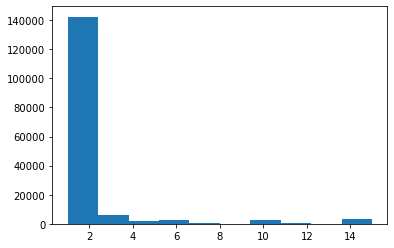

In [13]:
# plot a histogram of texts per author
plt.hist(texts_per_auth, bins=10)

avg samples per author: 172.228125
median samples per author: 59.0
std of samples per author: 275.50265621947165
min samples per author: 1
max samples per author: 1907


(array([1235.,  155.,   69.,   50.,   37.,   22.,   15.,   11.,    3.,
           3.]),
 array([1.0000e+00, 1.9160e+02, 3.8220e+02, 5.7280e+02, 7.6340e+02,
        9.5400e+02, 1.1446e+03, 1.3352e+03, 1.5258e+03, 1.7164e+03,
        1.9070e+03]),
 <BarContainer object of 10 artists>)

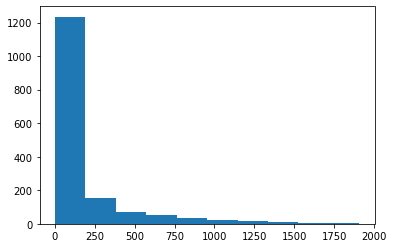

In [9]:
# plot a histogram of fandoms per author
# how many samples per author? 

def get_auths_per_fndm(fndm):
    return len(data[data['fandom1'] == fndm])

auth_per_fndm = []
all_fndms = pd.unique(data['fandom1'])
with Pool(8) as p:
    auth_per_fndm.append(p.map(get_auths_per_fndm, all_fndms))

print(f'avg samples per author: {np.mean(auth_per_fndm)}')
print(f'median samples per author: {np.median(auth_per_fndm)}')
print(f'std of samples per author: {np.std(auth_per_fndm)}')
print(f'min samples per author: {np.min(auth_per_fndm)}')
print(f'max samples per author: {np.max(auth_per_fndm)}')

(array([617., 288., 162.,  95.,  73.,  55.,  33.,  29.,  19.,  19.,  16.,
         15.,  14.,  15.,   9.,  13.,   8.,  10.,   9.,  10.,   9.,   4.,
         10.,   9.,   5.,   6.,   1.,   8.,   3.,   4.,   6.,   2.,   2.,
          2.,   3.,   3.,   2.,   3.,   3.,   0.,   2.,   0.,   1.,   0.,
          0.,   0.,   1.,   1.,   0.,   1.]),
 array([1.00000e+00, 3.91200e+01, 7.72400e+01, 1.15360e+02, 1.53480e+02,
        1.91600e+02, 2.29720e+02, 2.67840e+02, 3.05960e+02, 3.44080e+02,
        3.82200e+02, 4.20320e+02, 4.58440e+02, 4.96560e+02, 5.34680e+02,
        5.72800e+02, 6.10920e+02, 6.49040e+02, 6.87160e+02, 7.25280e+02,
        7.63400e+02, 8.01520e+02, 8.39640e+02, 8.77760e+02, 9.15880e+02,
        9.54000e+02, 9.92120e+02, 1.03024e+03, 1.06836e+03, 1.10648e+03,
        1.14460e+03, 1.18272e+03, 1.22084e+03, 1.25896e+03, 1.29708e+03,
        1.33520e+03, 1.37332e+03, 1.41144e+03, 1.44956e+03, 1.48768e+03,
        1.52580e+03, 1.56392e+03, 1.60204e+03, 1.64016e+03, 1.67828e+03,
 

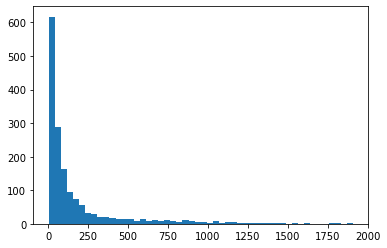

In [14]:
plt.hist(auth_per_fndm, bins=50)

In [18]:
# plot a histogram of authors per fandom
# plot a histogram of fandoms per author
# how many samples per author? 
def get_fndms_per_auth(auth):
    return len(pd.unique(data[data['auth1'] == auth]['fandom1']))

fndm_per_auth = []
with Pool(8) as p:
    fndm_per_auth.append(p.map(get_fndms_per_auth, all_auths))

print(f'avg samples per author: {np.mean(fndm_per_auth)}')
print(f'median samples per author: {np.median(fndm_per_auth)}')
print(f'std of samples per author: {np.std(fndm_per_auth)}')
print(f'min samples per author: {np.min(fndm_per_auth)}')
print(f'max samples per author: {np.max(fndm_per_auth)}')

avg samples per author: 1.255283811712111
median samples per author: 1.0
std of samples per author: 0.7847712381517544
min samples per author: 1
max samples per author: 5


(array([139838.,   9806.,   3944.,   3092.,   3479.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. ]),
 <BarContainer object of 5 artists>)

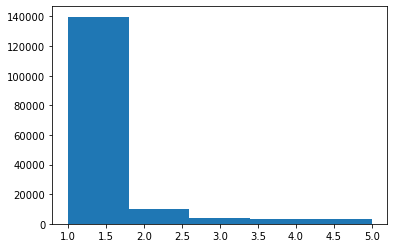

In [20]:
plt.hist(fndm_per_auth, bins=5)

In [17]:
# What is the accuracy on the dataset if we just predict the most common author/score? - Low AF, not even worth doing